# Pipelines
* Recent: less than 30 days
* Old: 30 days
* Stale: 90 days

In [1]:
# include common code and config
# selected_pi = 10
%run PIQM_Bootstrap.ipynb

{'pi': 'PI11', 'id': 11, 'start': '2021-06-16T00:00:00Z', 'started': '2021-06-16', 'finish': '2021-09-15T23:59:59Z'}


In [2]:
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
df_pipelines = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: 2008-01-01T00:00:00Z, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "projects" and r._field == "pipeline_last_run_finished")
        |> drop(columns:["_measurement", "_field", "_time", "_start", "_stop"])
        |> group()""".format(current_pi))
# .agg(['count', 'size', 'nunique'])
df_pipeline_status = df_pipelines[["pipeline_last_run_status", "_value"]].groupby(["pipeline_last_run_status"]).agg(['count', 'size', 'nunique']).reset_index()
df_pipeline_status['pipeline_last_run_status'] = df_pipeline_status['pipeline_last_run_status'].str.title()
df_pipeline_status['count'] = df_pipeline_status['_value']['count']
# print(df_pipeline_status)
old_threshold = 30 * 24 * 60 * 60 # 30 days
stale_threshold = 90 * 24 * 60 * 60 # 90 days
df_pipelines['age'] = current_timestamp - df_pipelines['_value']
df_pipelines["stale_pipeline"] = pandas.cut(x=df_pipelines['age'],
                                            bins=[0, 1, old_threshold, stale_threshold, float('Inf')],
                                            labels=['Never', 'Recent', 'Old', 'Stale'], right=False)

df_pipelines.loc[df_pipelines['_value'] < 1,'stale_pipeline'] = 'Never'
df_pipelines['how_many'] = 1
df_pipelines['total'] = 'Total'
df_pipelines

result table        _value got_coverage got_linting got_rtd got_tests  \
0    _result     0  1.630299e+09            0           0       0         0   
1    _result     0  1.630264e+09            0           0       0         0   
2    _result     0  1.630296e+09            0           0       0         0   
3    _result     0  1.597338e+09            0           0       0         0   
4    _result     0  0.000000e+00            0           0       0         0   
..       ...   ...           ...          ...         ...     ...       ...   
176  _result     0  1.626102e+09            1           1       1         1   
177  _result     0  1.629902e+09            1           1       1         1   
178  _result     0  1.629982e+09            1           1       1         1   
179  _result     0  1.630071e+09            1           1       1         1   
180  _result     0  1.630272e+09            1           1       1         1   

           id       license pipeline_last_run_status  \
0    12828461    apache-2.0                   failed   
1    13372840       unknown                   failed   
2    13540781  bsd-3-clause                   failed   
3    14333804  bsd-3-clause                  success   
4    15077844  bsd-3-clause                  unknown   
..        ...           ...                      ...   
176  25588125  bsd-3-clause                  success   
177  26389323  bsd-3-clause                 canceled   
178  27507143         other                  success   
179  28761400  bsd-3-clause                  success   
180   9673989         other                   failed   

                                             project           age  \
0                ska-telescope/sdp/ska-sdp-par-model  9.773890e+04   
1                       ska-telescope/cpp_build_base  1.325643e+05   
2               ska-telescope/templates/cpp-template  1.000451e+05   
3                          ska-telescope/sdc/ska-sdc  3.305834e+07   
4                   ska-telescope/CUDA_Deconvolution  1.630396e+09   
..                                               ...           ...   
176                 ska-telescope/ska-csp-lmc-common  4.294143e+06   
177  ska-telescope/sdi/ska-cicd-artefact-validations  4.943566e+05   
178                         ska-telescope/ska-db-oda  4.140249e+05   
179        ska-telescope/sdp/ska-sdp-benchmark-tests  3.253331e+05   
180                 ska-telescope/ska-tango-examples  1.247149e+05   

    stale_pipeline  how_many  total  
0           Recent         1  Total  
1           Recent         1  Total  
2           Recent         1  Total  
3            Stale         1  Total  
4            Never         1  Total  
..             ...       ...    ...  
176            Old         1  Total  
177         Recent         1  Total  
178         Recent         1  Total  
179         Recent         1  Total  
180         Recent         1  Total  

[181 rows x 15 columns]

In [3]:
df_state_age = df_pipelines[["pipeline_last_run_status", "stale_pipeline", "id"]]\
    .groupby(["pipeline_last_run_status", "stale_pipeline"])\
    .agg(['count', 'size', 'nunique']).reset_index()
df_state_age['count'] = df_state_age['id']['count']
# .agg(['count', 'size', 'nunique'])
# df_state_age = df_state_age[df_state_age["id"] != 0]

df_state_age = df_state_age[["pipeline_last_run_status", "stale_pipeline", "count"]]\
    .rename(columns={"pipeline_last_run_status": "Last run status", "stale_pipeline": "Stale"})\
    .sort_values(["count"], ascending=False)

df_state_age.style.hide_index()\
    .set_properties(subset=['Last run status', 'Stale'], **{'text-align': 'left'})\
    .set_table_styles([{'selector': 'th', 'props': [('text-align', 'left')]}])\
    .set_caption('SKA Pipeline Last Run')\
    .set_table_styles([{
    'selector': 'caption',
    'props': [
        ('color', 'black'),
        ('font-size', '16px'),
        ('font-weight', 'bold'),
        ('text-align', 'center')
    ]}])


# df_state_age


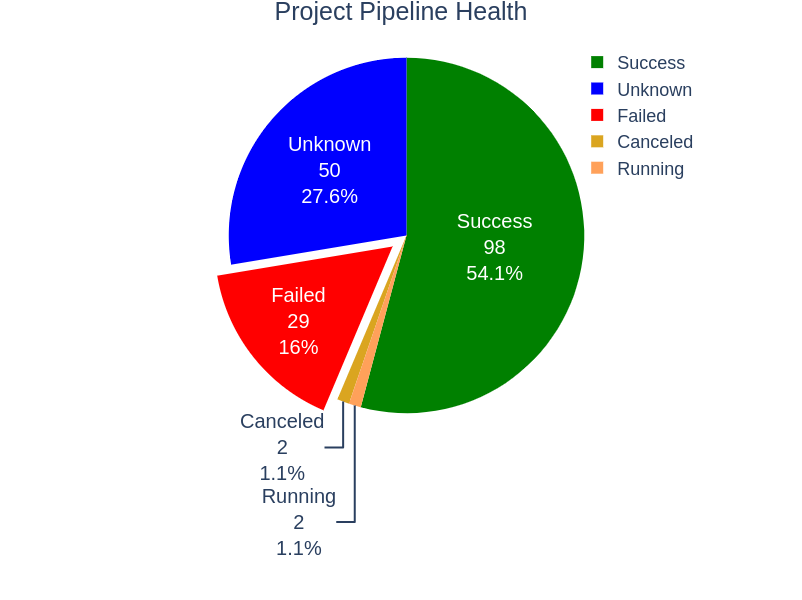

In [4]:
fig = px.pie(df_pipeline_status, values='count',
             names='pipeline_last_run_status',
             title='Project Pipeline Health',
             color='pipeline_last_run_status', 
#              color_discrete_sequence=px.colors.sequential.RdBu)
             color_discrete_map={
                "Success": "green",
                "Unknown": "blue",
                "Failed": "red",
                "Canceled": "goldenrod"})
fig.update_layout(yaxis=dict(titlefont_size=16,tickfont_size=14,),
                  height=600, title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)', 
                  font=dict(size=18,), 
                  margin = dict(t=40, l=0, r=0, b=0),
                 legend=dict(
                        yanchor="top",
                        y=0.99,
                        xanchor="left",
                        x=0.80
                    ))
fig.update_traces(hoverinfo='label+percent', textinfo='value+percent+label', textfont_size=20, pull=[0, 0.1, 0, 0])
fig.show()


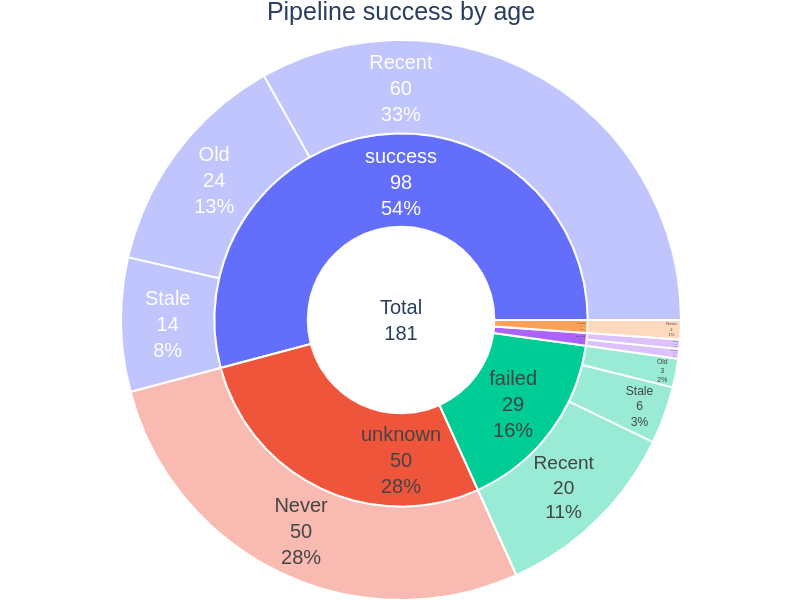

In [5]:
import plotly.express as px
fig = px.sunburst(df_pipelines, 
                  title="Pipeline success by age",
                  height=600,
                  path=['total', 'pipeline_last_run_status', 'stale_pipeline'], 
                  values='how_many', 
                  branchvalues="total",
#                  color_discrete_map={'Total': 'white'}
                 )


fig.update_traces(textinfo='label+value+percent entry', 
                  textfont_size=20, 
                  insidetextorientation='horizontal',
                  leaf={'opacity': 0.4},
                  marker={'line': {'width': [2 for i in range(len(df_pipelines))], 'color': '#fff'}},
                 )

fig.update_layout(yaxis=dict(titlefont_size=16,tickfont_size=14,),
                  height=600, title_x=0.5, paper_bgcolor='rgba(0,0,0,0)',
                  plot_bgcolor='rgba(0,0,0,0)', font=dict(size=18,),
                  margin = dict(t=40, l=0, r=0, b=0),)

fig.show()

In [13]:
from datetime import datetime
current_timestamp = int(datetime.now().timestamp())
query_api = client.query_api()
df_skampi_pipelines = query_api.query_data_frame(
    """from(bucket: "gitlab_metrics") 
        |> range(start: 2008-01-01T00:00:00Z, stop: {0[finish]}) 
        |> filter(fn: (r) => r._measurement == "pipelines" and r._field == "test_success" and r.project == "ska-telescope/ska-skampi")
        |> drop(columns:["_measurement", "_field", "_start", "_stop", "project", "project_id"])
        |> group()""".format(current_pi))
df_skampi_pipelines

result table                            _time  _value    created_by  \
0   _result     0 2019-03-26 13:53:25.958000+00:00     0.0  bartashevich   
1   _result     0 2019-03-26 13:58:50.964000+00:00     0.0  bartashevich   
2   _result     0 2019-03-26 14:04:41.460000+00:00     0.0  bartashevich   
3   _result     0 2019-03-26 14:28:28.490000+00:00     0.0  bartashevich   
4   _result     0 2019-03-26 14:59:45.176000+00:00     0.0  bartashevich   
5   _result     0 2019-03-26 15:11:49.820000+00:00     0.0  bartashevich   
6   _result     0 2019-03-22 15:08:04.299000+00:00     0.0    matteo1981   
7   _result     0 2019-03-22 15:13:01.347000+00:00     0.0    matteo1981   
8   _result     0 2019-03-22 15:42:31.756000+00:00     0.0    matteo1981   
9   _result     0 2019-03-28 16:20:57.198000+00:00     0.0    matteo1981   
10  _result     0 2019-03-28 16:24:53.651000+00:00     0.0    matteo1981   
11  _result     0 2019-03-28 16:30:24.676000+00:00     0.0    matteo1981   
12  _result     0 2019-03-28 16:35:07.349000+00:00     0.0    matteo1981   
13  _result     0 2019-03-28 16:37:48.226000+00:00     0.0    matteo1981   
14  _result     0 2019-03-28 17:27:38.308000+00:00     0.0    matteo1981   
15  _result     0 2019-03-28 17:30:29.131000+00:00     0.0    matteo1981   
16  _result     0 2019-03-28 17:33:47.812000+00:00     0.0    matteo1981   
17  _result     0 2019-03-28 17:38:24.353000+00:00     0.0    matteo1981   
18  _result     0 2019-03-29 08:31:16.986000+00:00     0.0    matteo1981   
19  _result     0 2019-03-29 09:32:57.003000+00:00     0.0    matteo1981   

   passed pipeline_id     ref   status  
0   False    53679678  master  success  
1   False    53681308  master  success  
2   False    53682727  master  success  
3   False    53688066  master  success  
4   False    53694936  master  success  
5   False    53697459  master  success  
6   False    53168355  master   failed  
7   False    53168942  master   failed  
8   False    53174719  master  success  
9   False    54101011  ST-152   failed  
10  False    54101931  ST-152   failed  
11  False    54103145  ST-152  success  
12  False    54103930  ST-152   failed  
13  False    54104350  ST-152  success  
14  False    54112386  ST-152  success  
15  False    54112851  ST-152  success  
16  False    54113306  ST-152   failed  
17  False    54113908  ST-152   failed  
18  False    54198387  master  success  
19  False    54208222  master  success